# 注意力汇聚：Nadaraya-Watson 核回归



In [1]:
import sys
sys.path.append('..')

In [2]:
import mindspore
import numpy as np
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as mnp
from d2l import mindspore as d2l

from mindspore import context
context.set_context(mode=context.PYNATIVE_MODE)

生成数据集

In [3]:
n_train = 50
# x_train, _ = mindspore.sort(mindspore.rand(n_train) * 5)
x_train = np.sort(np.random.rand(n_train) * 5)
x_train = mindspore.Tensor(x_train, mindspore.float32)
def f(x):
    return 2 * mnp.sin(x) + x**0.8

y_train = f(x_train) + mindspore.Tensor(np.random.normal(0.0, 0.5, (n_train,)), mindspore.float32)
x_test = mnp.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

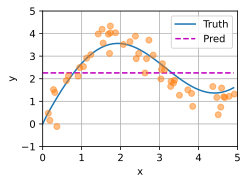

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test.asnumpy(), [y_truth.asnumpy(), y_hat.asnumpy()], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train.asnumpy(), y_train.asnumpy(), 'o', alpha=0.5);

y_hat = mnp.repeat(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

非参数注意力汇聚

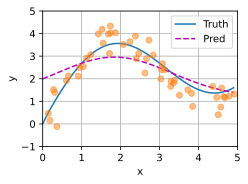

In [5]:
X_repeat = x_test.repeat(n_train).reshape((-1, n_train))
attention_weights = nn.Softmax(axis=1)(-(X_repeat - x_train)**2 / 2)
y_hat = mnp.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

注意力权重

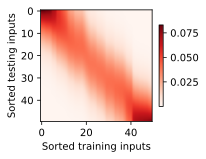

In [6]:
attention_weights = mnp.expand_dims(mnp.expand_dims(attention_weights, 0), 0)
d2l.show_heatmaps(attention_weights,
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

带参数注意力汇聚
假定两个张量的形状分别是$(n,a,b)$和$(n,b,c)$，
它们的批量矩阵乘法输出的形状为$(n,a,c)$

In [7]:
X = mnp.ones((2, 1, 4))
Y = mnp.ones((2, 4, 6))
ops.BatchMatMul()(X, Y).shape

(2, 1, 6)

使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [8]:
weights = mnp.ones((2, 10)) * 0.1
values = mnp.arange(20.0).reshape((2, 10))
ops.BatchMatMul()(mnp.expand_dims(weights, 1), mnp.expand_dims(values, -1))

Tensor(shape=[2, 1, 1], dtype=Float32, value=
[[[ 4.50000000e+00]],
 [[ 1.45000000e+01]]])

带参数的注意力汇聚

In [9]:
class NWKernelRegression(nn.Cell):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = mindspore.Parameter(mindspore.Tensor(np.random.rand(1,), mindspore.float32))
                                        
    def construct(self, queries, keys, values):
        queries = queries.repeat(keys.shape[1]).reshape((-1, keys.shape[1]))
        attention_weights = ops.Softmax(axis=1)(
            -((queries - keys) * self.w)**2 / 2)
        self.attention_weights = attention_weights
        return ops.BatchMatMul()(mnp.expand_dims(attention_weights, 1), \
                                 mnp.expand_dims(values, -1)).reshape(-1)

将训练数据集变换为键和值

In [10]:
X_tile = mnp.tile(x_train, (n_train, 1))
Y_tile = mnp.tile(y_train, (n_train, 1))
keys = X_tile[(1 - mnp.eye(n_train)).astype(mindspore.int32)].reshape((n_train, -1))
values = Y_tile[(1 - mnp.eye(n_train)).astype(mindspore.int32)].reshape((n_train, -1))

In [11]:
class NetWithLoss(nn.Cell):
    def __init__(self, network, loss):
        super().__init__()
        self.network = network
        self.loss = loss
        
    def construct(self, *inputs):
        y_hat = self.network(*inputs[:-1])
        loss = self.loss(y_hat, inputs[-1])
        loss = (loss / 2).sum()
        return loss

训练带参数的注意力汇聚模型

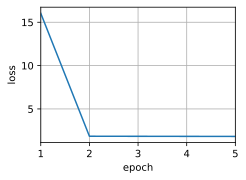

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
optim = nn.SGD(net.trainable_params(), 0.5)
net_with_loss = NetWithLoss(net, loss)
trainer = d2l.Train(net_with_loss, optim)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    l = trainer(x_train, keys, values, y_train) / 2
    print(f'epoch {epoch + 1}, loss {float(l.sum().asnumpy()):.6f}')
    animator.add(epoch + 1, float(l.sum().asnumpy()))

预测结果绘制

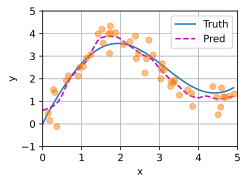

In [13]:
keys = mnp.tile(x_train, (n_test, 1))
values = mnp.tile(y_train, (n_test, 1))
y_hat = mnp.expand_dims(net(x_test, keys, values), 1)
plot_kernel_reg(y_hat)

曲线在注意力权重较大的区域变得更不平滑

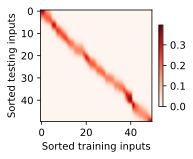

In [14]:
attention_weights = mnp.expand_dims(mnp.expand_dims(net.attention_weights, 0), 0)
d2l.show_heatmaps(attention_weights,
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')